In [1]:
import csv
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from nltk.stem.snowball import SnowballStemmer
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
import seaborn as sns

# Intializing the context
spark = SparkSession\
        .builder\
        .appName("FinalPJ10")\
        .getOrCreate()
sc = spark.sparkContext
sql_sc = SQLContext(sc)



## 1. What is the value proposition driving the analytic question?


In this task, we are aiming at helping home depot improve their customer's shopping experience by finding the relevance of search results to provide more accurate search results and increase the sales of home depot. By given the several datasets, we will select relevant features and algorithms to build the model and find the most effective methods to improve their current search algorithm. As kaggle mentioned, Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. In this task, we will build the predictive model to predict the search relevance for each search queries and products.


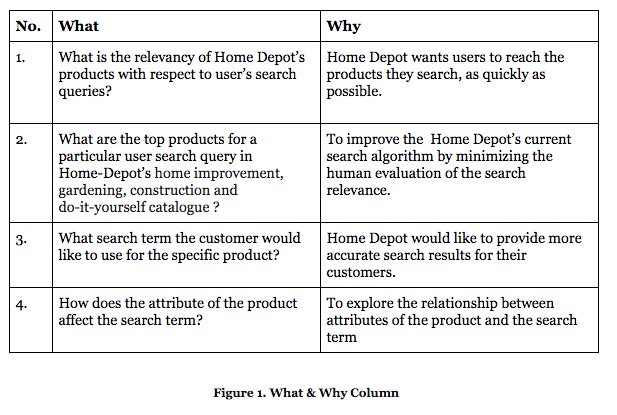

In [41]:
from IPython.display import Image
Image(filename='/Users/Raina/Desktop/Spring2017/Task15/image/what_why.png')

## 2. How does the data available speak to the problem being posed?  

In [2]:
# load data
test_data = pd.read_csv("/Users/Raina/Desktop/Spring2017/Task15/data_set/test.csv", encoding="ISO-8859-1")
train_data = pd.read_csv('/Users/Raina/Desktop/Spring2017/Task15/data_set/train.csv', encoding="ISO-8859-1")
attributes = pd.read_csv("/Users/Raina/Desktop/Spring2017/Task15/data_set/attributes.csv")
product_description = pd.read_csv("/Users/Raina/Desktop/Spring2017/Task15/data_set/product_descriptions.csv")


Before engineering the features and make the predictions, it is important to explore the data and get the initial insights. Homedepot provides 4 files of interest for exploration (train.csv,test.csv,product_descriptions.csv,attributes.csv,sample_submission).
The train data set contains id, product_uid, product_title, search_term and relevance. Home Depot has crowdsourced the search/product pairs, while each pair was examined by at least three human raters, who defined the integer scores: 
- 1 ( not relevant ).
- 2 ( Partially or somewhat relevant ).
- 3 ( highly relevant ). 

### Bring training data


In [3]:
train_data.head()

,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74067 entries, 0 to 74066
Data columns (total 5 columns):
id               74067 non-null int64
product_uid      74067 non-null int64
product_title    74067 non-null object
search_term      74067 non-null object
relevance        74067 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.8+ MB


- The train data has 74067 rows. The figure below exams the distribution of relevance across the trainning data, we can see that most of the products in the train dataset are relevant to the corresponding search queries, and the medium relevance score is 2.33


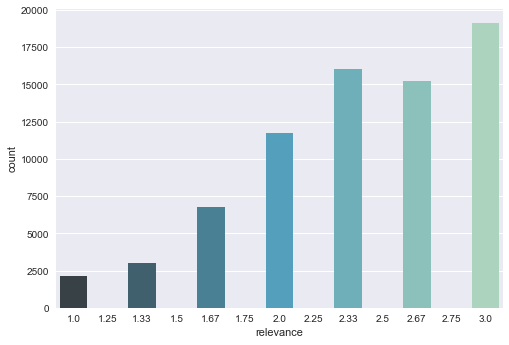

In [5]:
sns.countplot(x="relevance", data=train_data, palette="GnBu_d")
plt.rcParams['figure.figsize']=(10,10)
plt.show()

### Bring test data

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166693 entries, 0 to 166692
Data columns (total 4 columns):
id               166693 non-null int64
product_uid      166693 non-null int64
product_title    166693 non-null object
search_term      166693 non-null object
dtypes: int64(2), object(2)
memory usage: 5.1+ MB


- In the test.csv file, it has 16693 rows

In [7]:
test_data.head()

,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


### Bring attributes data 

In [8]:
attributes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2044803 entries, 0 to 2044802
Data columns (total 3 columns):
product_uid    float64
name           object
value          object
dtypes: float64(1), object(2)
memory usage: 46.8+ MB


- In the attributes.csv file, it has 2044803 rows

In [9]:
attributes.head()

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


### Bring product description data

In [10]:
product_description.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124428 entries, 0 to 124427
Data columns (total 2 columns):
product_uid            124428 non-null int64
product_description    124428 non-null object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB


- In the product description file, it has 124428 row. 

In [11]:
product_description.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


### Train data and test data overlap

The train dataset and test data, they both have the same columns (id, product_uid, product_title, search_term, relevance). While the relevance column does not included in the test dataset. In terms of product_uid, the train data set contains a total of 54667 unique product_uid, while test data contains a total of 97460. From the first figure below, we can see only a total of 27699(22.26%) are common. The total number of unique product_uids across both the train and test is 124428. 

In terms of search_term, the train data set contains a total of 11795 unique search_term, while test data contains a total of 22427. From the second figure below, we can see a total of 9621(39.11%) are common. The total number of unique search_term across both the train and test is 24601.

Rather than make the predictions on search quries and products which the model has been seen during the training, the predictions for new search quries and products might be harder. The percentage information shows that it's important to have an evenly cross-validation splits. than for queries and products which the model has seen during training. Otherwise, the parameters tuned on the validation data set can be far from optimal, and we will also get a lower score.


<font color='grey'>reference: https://www.kaggle.com/briantc/homedepot-first-dataexploreation-k</font>

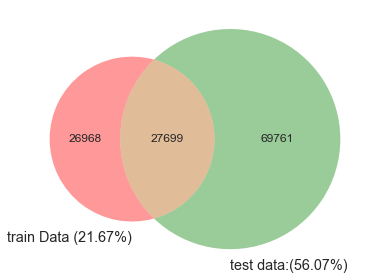

In [14]:
from matplotlib_venn import venn2
venn2([set(train_data["product_uid"]), set(test_data["product_uid"])],
set_labels=('train Data (21.67%)', 'test data:(56.07%) '))
plt.rcParams['figure.figsize']=(6,6)
plt.show()

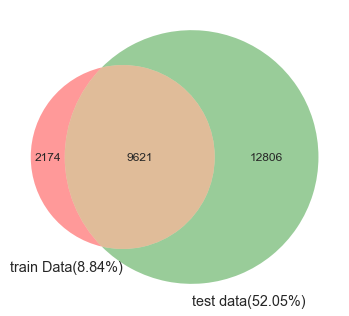

In [15]:
venn2([set(train_data["search_term"]), set(test_data["search_term"])],
set_labels=('train Data(8.84%)', 'test data(52.05%)'))
plt.rcParams['figure.figsize']=(6,6)
plt.show()

### Features


For Home Depot provided datasets, it contains the pair of user search queries, product title, product description and the relevance which is from 1 (not relevant) to 3 (highly relevant). 

This task requires us to build the predictive model to predict the search relevance for each user’s search queries. The first idea comes in our mind is using tokenizer to separate search queries into word and then applied it to the hashingTF to calculate each word’s frequency. It is our baseline model features. Based on the baseline model performance, we explore more features. We add new feature called category. Category was extracted based on home depot website’s category considering functionality (e.g Kitchen, Hardware, Heating and Cooling etc.) by using regular expression with attributes table. 

Then, we remove the stop words after applying tokenizer on search term, product description, product title since many stop words are meaningless which will decrease the accuracy of the model. Then, we calculate the distance between search terms and product descriptions, product titles by using cosine similarity, and jaccard similarity between other features words.

Considering the importance of information retrieval, we use the common way to compute the inverse document frequency. Therefore, we consider to build word  vector by word2vec and calculate the TF-IDF scores.
Besides the product title and product description, the other idea we got from attributes table. We use the match word to match the different specific attributes like  brand name, color and materials and then applied on jaccard similarity to find the difference. 


### Algorithm 


For this task, we think that it should be the supervised regression problem since the label value is the search relevance score which is the numeric value. We applied the linear regression in baseline model and then applied on the random forest. 


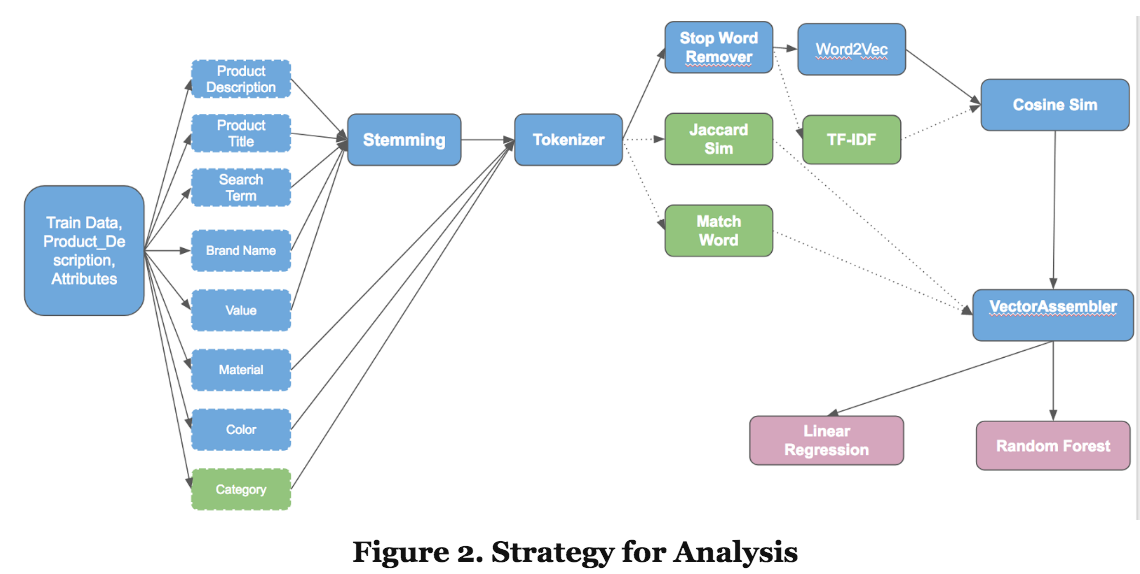

In [20]:
from IPython.display import Image
Image(filename='/Users/Raina/Desktop/Spring2017/Task15/image/strategy_analysis.png')

## 3. What is acceptable performance for this task?

For this challenge, the performance of the model was evaluated using root mean squared error (RMSE). According to Duke University, there is no absolute criterion for a "good" value of RMSE. The threshold for RMSE depends on the units in which the variable is measured and on the degree of forecasting accuracy, as measured in those units, which is sought in a particular application. Depending on the choice of units, the RMSE of your best model could be measured in zillions or one-zillionths. It is not reasonale to state "the model is good (bad) because the root mean squared error is less (greater) than x", unless you are referring to a specific degree of accuracy that is relevant to your forecasting application. But in common sense, the RMS should better smaller than 1, the RMS around 0.5 means the closer the fit is to the data. 


<font color='grey'>reference: https://people.duke.edu/~rnau/compare.htm</font>

## 4. What is the actionable information that can be delivered?


Using actionable information can help Homde Depot to make specific business decisions. 

Actionable information should be specific, timely, comprehensive and predictive, but more importantly, we should exam that whether the informaion is useful to making a decision or solving a problem. Data by itself does not lead to actionable insights. For instance, the search/product pair is important and credible, but it is not actionable. 
In order to turn the data into actionable information , we should understand the business questions that are trying to be solved. However, a dashboard show that 'What are the top products for a particular user search query in Home-Depot’s' is far more actionable. Once the business questions are known, we are able to understand which specific data needs to be analyzed and collected. 

## 5. What is the additional insight to the problem or solution that can be delivered?


We generated a new feature called “category” indicating the category of every product based on the Home Depot category list by sensing keywords in its descriptions and attributes. Knowing the category of a product helps its identification. As a result, the new feature improved the performance of the model. 

As for the future, it would be reasonable to identify the age, gender and nationality of the customer from the search term. We could analyze the phrase and word use to determine those attributes so that we could have a better understanding of the customer, thus improve performance of the prediction.